# Cosyne 2018 Project: Synaptic Computation in the NEF

**Preliminary Abstract**:

Non-linear interaction in the dendritic tree is known to be an important computational resource in biological neurons. Yet, high-level neural compilers ‒ such as the Neural Engineering Framework (NEF) ‒ neither include non-linear synaptic interaction in their models, nor exploit these interactions systematically. In this study, we extend the NEF towards synaptic computation of non-linear multivariate functions, such as controlled shunting, multiplication, maximum, and the Euclidean norm. We present a theoretical framework that provides sufficient conditions under which non-linear synaptic interaction yields a similar precision compared to traditional NEF methods, while reducing the number of layers, neurons, and latency in the network. The proposed method lends itself to increasing the computational power of neuromorphic hardware systems and improves the NEF's biological plausibility by mitigating one of its long-standing limitations, namely its reliance on linear, current-based synapses. We perform a series of numerical experiments with a conductance-based two-compartment LIF neuron model. Preliminary results show that non-linear interaction of conductance-based synapses is sufficient to compute a wide variety of non-linear functions with performance competitive to using an additional layer of neurons as a non-linearity.

In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import nengo
nengo.rc.set('decoder_cache', 'enabled', 'False')

import scipy.optimize
import multiprocessing

## Empirical Neuron Simulation

The following code implements empirical simulation of a single spiking neuron. This simulation is used to extract the Neuron Response curve, i.e. the average activity of the neuron for a sweep over the excitatory and inhibitory input spike rate.

In [2]:
# Neuron and synapse parameters
gC = 100e-9
gLDen = 12.5e-9
gLSom = 50e-9
cmDen = 0.25e-9
cmSom = 1.0e-9
EE = 20e-3
EI = -75e-3
EL = -65e-3
tau_syn_e = 5e-3
tau_syn_i = 10e-3
w_syn_e = 100e-9
w_syn_i = 100e-9
v_thresh = -50e-3
tau_ref = 2e-3
tau_rc = cmSom / gLSom

# Input rates, convert to average conductances gEs and gIs
rEs = np.linspace(0, 7500, 10)
rIs = np.linspace(0, 5000, 10)
gEs = rEs * w_syn_e
gIs = rIs * w_syn_i

### Helper functions

In [3]:
def spike_train(lambda_=0.01, T=10.0):
    t = 0
    res = []
    while t < T:
        t += np.random.exponential(lambda_)
        res.append(t)
    return res

def lif_rate(J):
    mask = 1 * np.logical_or(
            np.logical_and(J > 1, gLSom > 0),
            np.logical_and(J < 0, gLSom < 0))
    t_spike = -np.log1p(-mask * 1.0 / (mask * J + (1 - mask))) * tau_rc
    return mask / (tau_ref + t_spike)

def lif_rate_inv(r):
    return -1 / (np.exp((r * tau_ref - 1) / (r * tau_rc)) - 1)

### Code for Empirical Neuron Simulation

#### Point Neuron with Conductance-Based Synapses

*Note:* This code is only included as a refference. It uses a C++ simulator backend provided by `nengo_conductance_synapses.sim_cond_exp`.

In [4]:
%%script false

def point_lif_cond_exp():
    from nengo_conductance_synapses import sim_cond_exp

    # Define all simulation parameters (these are the default values)
    task = sim_cond_exp.task(
             cm=cmSom,
             g_leak=gLSom,
             v_thresh=v_thresh,
             v_rest=EL,
             v_reset=EL,
             tau_refrac=tau_ref,
             tau_syn_e=tau_syn_e,
             w_syn_e=w_syn_e,
             e_rev_syn_e=EE,
             tau_syn_i=tau_syn_i,
             w_syn_i=w_syn_i,
             e_rev_syn_i=EI,
             repeat=10,
             T=1.0);

    # Create a SimCondExp object and submit the task, wait until the simulation
    # has finished
    output_rates = np.zeros((len(rIs), len(rEs)))
    with sim_cond_exp.SimCondExp() as sim:
        def make_callback(i, j):
            def callback(_, rates):
                output_rates[j, i] = np.mean(rates)
            return callback
        for i, rE in enumerate(rEs):
            for j, rI in enumerate(rIs):
                task["input"]["rate_e"] = rE
                task["input"]["rate_i"] = rI
                sim.submit(task, make_callback(i, j))
    return output_rates

#### LIF Neuron with two Compartments and Conductance-Based Synapses

In [5]:
%%script false 

def simulate_two_compartement_lif(exc_spike_rate,
                                  inh_spike_rate,
                                  T=1.0,
                                  dt=1e-5):
    # Create the output arrays, including voltage and current traces
    ts = np.arange(0, T, dt)
    n_samples = len(ts)
    vDens, vSoms, iSyns, gEs, gIs = np.empty((5, n_samples))
    spikes = []

    # Generate the excitatory and inhibitory input spike trains
    exc_spikes = spike_train(1.0 / (exc_spike_rate + 1e-3), T)
    inh_spikes = spike_train(1.0 / (inh_spike_rate + 1e-3), T)
    gE = 0.0
    gI = 0.0

    # Iterate over all timesteps
    vDen = vSom = EL
    tRef = 0.0
    for i, t in enumerate(ts):
        # Synaptic dynamics
        gE += -dt * gE / tau_syn_e
        gI += -dt * gI / tau_syn_i
        while (len(exc_spikes) > 0 and t > exc_spikes[0]):
            gE += w_syn_e
            del exc_spikes[0]
        while (len(inh_spikes) > 0 and t > inh_spikes[0]):
            gI += w_syn_i
            del inh_spikes[0]

        # Calculate the synaptic current from the compartemental voltages in the
        # last timestep (this is what couples the compartements)
        iSyn = (vDen - vSom) * gC

        # Advance the simulation independently for the dendritic and somatic
        # compartement
        vDen += dt * ((EE - vDen) * gE + (EI - vDen) * gI +
                      (EL - vDen) * gLDen - iSyn) / cmDen
        vSom += dt * ((EL - vSom) * gLSom + iSyn) / cmSom

        # Implement the spike generation mechanism in the soma
        if vSom > v_thresh:
            tRef = tau_ref
            spikes.append(t)
        if tRef > 0.0:
            vSom = EL
            tRef = np.maximum(0.0, tRef - dt)

        # Record the somatic and dendritic voltages as well as the copuling
        # current
        vDens[i] = vDen
        vSoms[i] = vSom
        iSyns[i] = iSyn
        gEs[i] = gE
        gIs[i] = gI

    # Use the median spike distance as frequency
    n_spikes = len(spikes)
    f_spike = n_spikes / T
    spikes = np.array(spikes)
    if n_spikes > 2:
        f_spike = 1 / np.median(spikes[1:] - spikes[:-1])

    return ts, vDens, vSoms, iSyns, gEs, gIs, f_spike

In [6]:
%%script false

def two_comp_lif_cond_exp(T=1.0, dt=1e-5, repeat=10):
    mrEs, mrIs = np.meshgrid(rEs, rIs)
    it = np.nditer(
            [mrEs, mrIs, None],
            [],
            [['readonly'], ['readonly'], ['writeonly', 'allocate']])

    for (rE, rI, rate) in it:
        f_spikes = np.zeros(repeat)
        for i in range(repeat):
            _, _, _, _, _, _, f_spikes[i] = simulate_two_compartement_lif(rE, rI, T, dt)
        rate[...] = np.mean(f_spikes)
    output_rates = it.operands[2]
    return output_rates

## Neuron Response Curve from Empirical Simulation

Run the actual neuron simulation. We will fit this to a model later, so we don't have to constantly perfrom numerical simulations.

In [7]:
%%script false

# Executing this code will take some time...
#output_rates = point_lif_cond_exp();
output_rates = two_comp_lif_cond_exp();

In [8]:
%%script false

fig, ax = plt.subplots()
contour = ax.contourf(rEs, rIs, output_rates, 10, cmap='viridis')
levels = contour.levels

ax.contour(rEs, rIs, output_rates, levels, colors=["w"], linestyles=[(0, (1, 3))])
ax.set_xlabel('Excitatory rate [$s^{-1}]$')
ax.set_ylabel('Inhibitory rate [$s^{-1}]$')
ax.set_title('Output Spike Rate')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(contour, cax=cax, orientation='vertical');

Separate the synaptic portion of the neuron from the neuron response curve.

In [9]:
%%script false

j_from_rate = lif_rate_inv(output_rates + 1e-6)

In [10]:
%%script false

fig, ax = plt.subplots()
contour = ax.contourf(rEs, rIs, j_from_rate, 10, cmap='viridis')
levels = contour.levels

ax.contour(rEs, rIs, j_from_rate, levels, colors=["w"], linestyles=[(0, (1, 3))])
ax.set_xlabel('Excitatory rate [$s^{-1}$]')
ax.set_ylabel('Inhibitory rate [$s^{-1}$]')
ax.set_title('Equivalent Somatic Current')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(contour, cax=cax, orientation='vertical');

## Fitting the Neuron Response Curve to a Rational Function

In [11]:
j_model_fun = lambda w, gE, gI: (w[0] + w[1] * gE + w[2] * gI) / (w[3] + w[4] * gE + w[5] * gI)

In [12]:
%%script false

valid = output_rates.flatten() > 1
mgEs, mgIs = np.meshgrid(gEs, gIs)
gE_train = mgEs.flatten()[valid]
gI_train = mgIs.flatten()[valid]
tar = j_from_rate.flatten()[valid]

err = lambda w: np.sqrt(np.mean((j_model_fun(w, gE_train, gI_train) - tar) ** 2))

w0 = np.array((gC * (v_thresh - EL) + gC, EE + 1, EI + 1, gC, 1, 1))
w0[0:3] *= 500
res = scipy.optimize.basinhopping(err, w0)
w = res.x / res.x[3] # Reduce DOFs

print("Weights:\n", w)
print("Error:\n", res.fun)

j_model = j_model_fun(w, mgEs.flatten(), mgIs.flatten()).reshape(mgEs.shape)

In [13]:
# Result of all the above calculations
w =  np.array((
     3.51649857e+00,
     2.33295706e+05,
    -1.39254970e+05,
     1.00000000e+00,
     2.24264021e+04,
     4.21362391e+04))

In [14]:
%%script false

fig, ax = plt.subplots()
contour = ax.contourf(gEs * 1e6, gIs * 1e6, j_model.reshape(mgEs.shape), levels, cmap='viridis')
ax.contour(gEs * 1e6, gIs * 1e6, j_from_rate, levels, linestyles=('--'), colors=('white'))
ax.set_xlabel('Excitatory conductance [$\mathrm{\mu S}$]')
ax.set_ylabel('Inhibitory conductance [$\mathrm{\mu S}$]')
ax.set_title('Somatic Current Fit (colour) vs. to Emprical (dashed)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(contour, cax=cax, orientation='vertical');

## Network setup

Here I manually generate standard parameters for a network of LIF neurons with three populations à 100 neurons each. The first two populations project onto the third population, but instead of computing the sum of the values represented by the first two populations we'd like to compute the product of the two values. In particular, I'm only concerned about positive input values, that is the product as operator $\cdot : [0, 1] \times [0, 1] \longrightarrow [0, 1]$.

The following code computes a set of parameters, tuning curves, and decoders for each population.

In [15]:
def generate_tuning_curves(N=100, max_rate=200, n=3):
    max_rates = np.random.uniform(max_rate / 2, max_rate, (n, N))
    intercepts = np.random.uniform(-0.95, 0.95, (n, N))
    encoders = np.random.choice([-1, 1], (n, N))
    neuron = nengo.LIF(tau_rc=cmSom / gLSom, tau_ref=tau_ref)
    gain, bias = neuron.gain_bias(max_rates, intercepts)

    # Calculate population tuning curves and decoders
    res = 100
    xs = np.linspace(-1, 1, res)
    As = np.zeros((n, res, N))
    decoders = np.zeros((n, N))
    for ni in range(n):
        for Ni in range(N):
            As[ni, :, Ni] = lif_rate(
                (xs * encoders[ni, Ni] * gain[ni, Ni] + bias[ni, Ni]))
            decoders[ni] = nengo.solvers.LstsqL2()(As[ni], xs)[0]

    return n, xs, As, gain, bias, encoders, decoders

In [16]:
%%script false

# Plot some tuning curves as an example of what they look like
n, xs, As, gain, bias, encoders, decoders = generate_tuning_curves()
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for ni in range(n):
    axs[ni].plot(xs, As[ni])
    if ni < 2:
        axs[ni].set_title("Pre population ({:d})".format(ni + 1))
    else:
        axs[ni].set_title("Post population")
    axs[ni].set_xlabel("Value $x$")
    axs[ni].set_ylabel("Firing rate");
    axs[ni].set_xlim(-1, 1)
    axs[ni].set_ylim(0, 200)
    axs[ni].get_yaxis().set_visible(ni == 0)

## Generating “Training” Data

In order to train the network, let's first generate some reference data. To this end I uniformly sample the 2D-input space and compute the desired product.

In [17]:
def generate_training_data(h=lambda x, y: x * y, res=20):
    # Generate sample points on a uniform grid
    xs = np.linspace(0, 1, res)
    data_in_x, data_in_y = np.meshgrid(xs, xs)
    data_in = np.array((data_in_x.flatten(), data_in_y.flatten()))

    # Generate the target data
    data_tar = h(data_in[0], data_in[1])

    return data_in, data_tar

def target_currents(data_tar, gain, bias, encoders):
    return data_tar[:, None] @ (gain * encoders)[None, :] + bias[None, :]

def population_activities(data_in, data_tar, gain, bias, encoders):
    assert gain.shape == bias.shape
    assert gain.shape[0] == encoders.shape[0]

    n = 3
    N = gain.shape[1]
    n_samples = data_in.shape[1]

    neuron = nengo.LIF(tau_rc=cmSom / gLSom, tau_ref=tau_ref)
    A = np.empty((n, N, n_samples))
    for Ni in range(N):
        A[0, Ni] = neuron.rates(data_in[0] * encoders[0, Ni], gain[0, Ni], bias[0, Ni])
        A[1, Ni] = neuron.rates(data_in[1] * encoders[1, Ni], gain[1, Ni], bias[1, Ni])
        A[2, Ni] = neuron.rates(data_tar * encoders[2, Ni], gain[2, Ni], bias[2, Ni])
    Apre = (A[0:2].reshape((2*N, n_samples))).T
    Apost = (A[2]).T
    return Apre, Apost

In [18]:
%%script false

# Plot the training data and population activities for some function h
h = lambda x, y: 0.5 * (x + y)

data_in, data_tar = generate_training_data(h)
Jpost = target_currents(data_tar, gain[2], bias[2], encoders[2])

fig, ax = plt.subplots()
ax.imshow(Jpost.T, vmin=0)
ax.set_title('Target currents per sample/neuron')
ax.set_xlabel("Sample number")
ax.set_ylabel("Neuron number")

fig, ax = plt.subplots()
ax.plot(data_in[0], label="First input dim.")
ax.plot(data_in[1], label="Second input dim.")
ax.plot(data_tar, linewidth=2, color='k', linestyle=(1, (1, 1)), label="Target output")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3)
ax.set_xlabel("Sample number")
ax.set_ylabel("Value")
ax.set_title("Input and output data in value space");

## Solve for Weight Matrices

Here, I use gradient descent with enforced non-negativity to solve for excitatory and inhibitory weight matrices $W_\mathrm{E}$ and $W_\mathrm{I}$ with size $200 \times 100$.

In [19]:
def solve_conductance_weight_matrices(Apre, Jpost, j_model_weights):
    assert Apre.shape[0] == Jpost.shape[0]
    m = Apre.shape[0]
    Npre = Apre.shape[1]
    Npost = Jpost.shape[1]

    a0, a1, a2, b0, b1, b2 = j_model_weights
    flt_best_err = None
    best_errs, errs = np.ones((2, Npost)) * np.inf
    WE, WI, best_WI, best_WE = np.zeros((4, Npre, Npost))
    WE, WI = np.ones((2, Npre, Npost)) * 2e-2
    gE, gI = Apre @ WE, Apre @ WI
    lambda_ = 0.1
    reg = 1e-3

    # Do not spend energy on optimizing for negative currents
    Jpost_non_neg = np.copy(Jpost)
    Jpost_non_neg[Jpost < 0] = -1

    # Code for solving a weight matrix for the given target function
    def gradient_descent_step(WE, WI):
        eta = lambda_ / m
        for i in range(Npost):
            for j in np.random.permutation(m):
                num = (a0 + a1 * Apre[j, :] @ WE[:, i] + a2 * Apre[j, :] @ WI[:, i])
                den = (b0 + b1 * Apre[j, :] @ WE[:, i] + b2 * Apre[j, :] @ WI[:, i])
                Jcur = num / den
                Jerr = Jpost_non_neg[j, i] - Jcur

                # Do not count negative outputs as error
                # if the target is negative as well
                if Jcur < 0 and Jpost_non_neg[j, i] < 0:
                    Jerr = 0

                # Add a L2 regularisation term
                Jerr += reg * (np.sum(WE[:, i] ** 2) + np.sum(WI[:, i]) ** 2)

                # Calculate the gradient
                WE_step = Jerr * (- (Apre[j, :] * a1) / den
                                  + (num * Apre[j, :] * b1) / (den ** 2) + 2 * reg * WE[:, i])
                WI_step = Jerr * (- (Apre[j, :] * a2) / den
                                  + (num * Apre[j, :] * b2) / (den ** 2) + 2 * reg * WE[:, i])

                # Descent the gradient!
                WE[:, i] -= eta * WE_step
                WI[:, i] -= eta * WI_step

                # Make sure the weights are not exorbitantly large
                WE[:, i] = np.clip(WE[:, i], None, 1e3)
                WI[:, i] = np.clip(WI[:, i], None, 1e3)

        return WE, WI
                

#    def calculate_tar_for_gE_given_gI(J, gI):
#        return (J * (b0 + b2 * gI) - (a0 + a2 * gI)) / (a1 - J * b1)

#    def calculate_tar_for_gI_given_gE(J, gE):
#        return (J * (b0 + b1 * gE) - (a0 + a1 * gE)) / (a2 - J * b2)

    def current_Jpost(WE, WI):
        num = (a0 + a1 * Apre @ WE + a2 * Apre @ WI)
        den = (b0 + b1 * Apre @ WE + b2 * Apre @ WI)
        return num / den

    # Alternating optimization of the excitatory and inhibitory weights
    i = 0
    while True:
        # Calculate the error. It is ok if negative target currents are
        # just negative in the optimized version.
        Jpost_opt = current_Jpost(WE, WI)
        Jpost_opt[np.logical_and(Jpost_opt < 0, Jpost_non_neg < 0)] = -1
        errs = np.sqrt(np.mean((Jpost_opt - Jpost_non_neg) ** 2, axis=0))
        # TODO: Add regularisation

        # Keep the best columns in WE, WI
        better = errs < best_errs
        best_errs[better] = errs[better]
        best_WE[:, better] = WE[:, better]
        best_WI[:, better] = WI[:, better]

        # Optimization controller -- measure the current error and abort once
        # the error no longer improves
        err = np.sqrt(np.mean(errs**2))
        best_err = np.sqrt(np.mean(best_errs**2))
        if flt_best_err is None:
            flt_best_err = best_err
        else:
            flt_best_err = best_err * 0.5 + flt_best_err * 0.5
            sys.stdout.write(("Current error: {:0.4f} " +
                              "Best error: {:0.4f} " +
                              "ΔE: {:0.4f} " +
                              "∑|WE|: {:0.2f} " +
                              "∑|WI|: {:0.2f}     \r").format(
                err,
                best_err,
                flt_best_err - best_err,
                np.sum(np.abs(WE)) / (np.prod(WE.shape)),
                np.sum(np.abs(WI)) / (np.prod(WI.shape))))
            sys.stdout.flush()
            if (i > 4 / lambda_):
                if (np.abs(flt_best_err - best_err) < 1e-4 * lambda_):
                    print("\nError not significantly decreasing, done.")
                    break

        # Add some noise to shake things up a little...
        WE = WE + np.random.normal(0, 1, (Npre, Npost)) * 1e-3
        WI = WI + np.random.normal(0, 1, (Npre, Npost)) * 1e-3

        # Perform a single gardient descent step
        gradient_descent_step(WE, WI)

        # Make sure the weight matrices are non-negative
        WE[WE < 0] = 0
        WI[WI < 0] = 0


        i = i + 1
        
    print("Final error:", best_err)
    print("Number of iterations:", i)
    return best_WE, best_WI

In [20]:
%%script false

Apre, Apost = population_activities(data_in, data_tar, gain, bias, encoders)

WE, WI = solve_conductance_weight_matrices(Apre, Jpost, w)

In [21]:
%%script false

Jpost_opt = j_model_fun(w, Apre @ WE, Apre @ WI)
Apost_opt = lif_rate(Jpost_opt)

fig, ax = plt.subplots()
ax.plot(Apost_opt @ decoders[2], linewidth=3.0, label="Decoded")
ax.plot(data_tar, 'k', linewidth=1.0, linestyle=(1, (1, 1)), label="Target", alpha=0.5)
ax.plot(data_tar, 'w', linewidth=1.0, linestyle=(0, (1, 1)), alpha=0.5)
ax.set_xlabel('Sample number')
ax.set_ylabel('Decoded value $\\phi(x, y)$')

rmse = np.sqrt(np.mean((Apost_opt @ decoders[2] - data_tar)**2))
ax.set_title('RMSE: {:0.4f}'.format(rmse));

In [22]:
%%script false

ni = [19] # Which post-neurons to inspect

fig, axs = plt.subplots(2, figsize=(6, 12))
axs[0].plot(Jpost_opt[:, ni], linewidth=3.0, label="Decoded")
axs[0].plot(Jpost[:, ni], 'k', linewidth=1.0, linestyle=(1, (1, 1)), label="Target", alpha=0.5)
axs[0].plot(Jpost[:, ni], 'w', linewidth=1.0, linestyle=(0, (1, 1)), alpha=0.5)
axs[0].set_title('Target current vs. decoded current')
axs[0].set_xlabel('Sample number')
axs[0].set_ylabel('Current $J$')
axs[0].set_ylim(-1, None)
axs[0].legend(loc='best')

axs[1].plot((Apre @ WE)[:, ni], label="$g_\mathrm{E}$", alpha=0.75)
axs[1].plot((Apre @ WI)[:, ni], label="$g_\mathrm{I}$", alpha=0.75)
axs[1].set_title('Decoded conductance functions $g_\mathrm{E}(x, y)$, $g_\mathrm{I}(x, y)$')
axs[1].set_xlabel('Sample number')
axs[1].set_ylabel('Conductance $g$')
axs[1].legend(loc='best');

## Benchmark code

In [23]:
def benchmark_cond_synapses_no_intermediate(φ, w, N):
    # Setup the population tuning curves
    n, xs, As, gain, bias, encoders, decoders = generate_tuning_curves(N=N)

    # Generate input and ouptut data, translate to pre- and post-synaptic activities
    data_in, data_tar = generate_training_data(φ)
    Apre, _ = population_activities(data_in, data_tar, gain, bias, encoders)

    # Calculate the target currents
    Jpost = target_currents(data_tar, gain[2], bias[2], encoders[2])

    # Solve for WE and WI
    print("Solving for weight matrices...")
    WE, WI = solve_conductance_weight_matrices(Apre, Jpost, w)

    # Evaluate the function on a finer grid
    print("Calculating RMSE...")
    data_test_in, data_test_tar = generate_training_data(φ, res=100)
    Apre, Apost_ground_truth = population_activities(data_test_in, data_test_tar, gain, bias, encoders)
    Jpost_opt = j_model_fun(w, Apre @ WE, Apre @ WI)
    Apost_opt = lif_rate(Jpost_opt)

    # Decode both Apost_truth and Apost_opt
    post_ground_truth_decoded = Apost_ground_truth @ decoders[2]
    post_opt_decoded = Apost_opt @ decoders[2]

    # Calculate the RMSE
    rmse_ground_truth = np.sqrt(np.mean((post_ground_truth_decoded - data_test_tar) ** 2))
    rmse_opt = np.sqrt(np.mean((post_opt_decoded - data_test_tar) ** 2))

    return rmse_opt, rmse_ground_truth

In [59]:
import nengo_dl
import tensorflow as tf


def benchmark_cur_synapses_intermediate(φ, N, backprop=False):
    # Fetch gain, bias, and encoders to be used for the source and target populations
    n, xs, As, gain, bias, encoders, decoders = generate_tuning_curves(N=N)
    
    if backprop:
        neuron = nengo_dl.SoftLIFRate(tau_rc=cmSom / gLSom, tau_ref=tau_ref)
    else:
        neuron = nengo.LIFRate(tau_rc=cmSom / gLSom, tau_ref=tau_ref)
        
    # Use the same L2 regularisation as in the gradient descent algorithm
    reg = 1e-3
    solver = nengo.solvers.LstsqL2(reg=reg)

    # Fetch the evaluation points
    data_in, data_tar = generate_training_data(φ)

    # Build a nengo network
    print("Solving for weight matrices...")
    net = nengo.Network()
    with net:
        net.config[nengo.Connection].synapse = None
        
        ens_X = nengo.Ensemble(
            N, 1, encoders=encoders[0].reshape(-1, 1),
            gain=gain[0], bias=bias[0], neuron_type=neuron,
            eval_points=np.unique(data_in[0])[:, None],
            label="X")
        ens_Y = nengo.Ensemble(
            N, 1, encoders=encoders[1].reshape(-1, 1),
            gain=gain[1], bias=bias[1], neuron_type=neuron,
            eval_points=np.unique(data_in[1])[:, None],
            label="Y")
        ens_tar = nengo.Ensemble(
            N, 1, encoders=encoders[2].reshape(-1, 1),
            gain=gain[2], bias=bias[2], neuron_type=neuron,
            label="Tar")
        ens_inter = nengo.Ensemble(N, 2,
            max_rates=nengo.dists.Uniform(100, 200), neuron_type=neuron,
            eval_points=data_in.T, radius=np.sqrt(2),
            label="Inter")
        
        # The next 5 lines are for nengo_dl
        node_X = nengo.Node(output=[0])
        node_Y = nengo.Node(output=[0])
        nengo.Connection(node_X, ens_X)
        nengo.Connection(node_Y, ens_Y)
        p_tar = nengo.Probe(ens_tar)

        c_xi = nengo.Connection(ens_X, ens_inter, transform=[[1], [0]], solver=solver)
        c_yi = nengo.Connection(ens_Y, ens_inter, transform=[[0], [1]], solver=solver)
        c_it = nengo.Connection(ens_inter, ens_tar,
                                function=lambda x: φ(x[0], x[1]), solver=solver)

    if not backprop:  # least squares
        sim = nengo.Simulator(net, progress_bar=False)
    else:        
        with net:
            #for ens in net.all_ensembles:
            #    ens.neuron_type = (
            #        nengo_dl.SoftLIFRate(tau_rc=cmSom / gLSom, tau_ref=tau_ref))
                
            # Only train the weight matrices to ens_inter, its
            # biases/encoders, and the decoders from ens_inter.
            nengo_dl.configure_settings(trainable=False)
            net.config[c_xi].trainable = True
            net.config[c_yi].trainable = True
            net.config[ens_inter].trainable = True
            net.config[c_it].trainable = True

        # nengo_dl hyperparameters
        learning_rate = 1e-7
        #momentum = 0.9
        p_minibatch = 1.0
        n_epochs = 400
        beta = 1000.
        
        # Use the same training data as Nengo gets.
        inputs = {node_X: data_in[0][:, None, None],
                  node_Y: data_in[1][:, None, None]}
        targets = {p_tar: data_tar[:, None, None]}

        #opt = tf.train.MomentumOptimizer(
        #    learning_rate=learning_rate,
        #    momentum=momentum,
        #    use_nesterov=True)
        opt = tf.train.GradientDescentOptimizer(learning_rate)
        
        sim = nengo_dl.Simulator(net, minibatch_size=int(p_minibatch * data_in.shape[1]))
                
        w = [
            sim.tensor_graph.get_tensor(sim.model.sig[c_it]["weights"]),
            sim.tensor_graph.get_tensor(sim.model.sig[ens_inter]["encoders"]),  # scaled_encoders
            sim.tensor_graph.get_tensor(sim.model.sig[c_xi]["weights"]),
            sim.tensor_graph.get_tensor(sim.model.sig[c_yi]["weights"]),
        ]
        
        def objective(o, t, w=w):
            return (tf.losses.mean_squared_error(t, o) +
                    beta * sum(tf.nn.l2_loss(w_i) for w_i in w))
        
        print("pre-training mse:", sim.loss(inputs, targets, "mse"))
        sim.train(inputs, targets, opt, objective=objective, n_epochs=n_epochs)
        print("post-training mse:", sim.loss(inputs, targets, "mse"))

    # Evaluate the function on a finer grid
    print("Calculating RMSE...")
    data_test_in, data_test_tar = generate_training_data(φ, res=100)
    Apre, Apost_ground_truth = population_activities(data_test_in, data_test_tar, gain, bias, encoders)

    # Calculate the input current for each neuron in the intermediate population
    enc = sim.data[ens_inter].scaled_encoders
    Jin_i_x = (enc @ (sim.data[c_xi].weights @ Apre[:, 0:N].T)).T
    Jin_i_y = (enc @ (sim.data[c_yi].weights @ Apre[:, N:2*N].T)).T
    Jin_i = Jin_i_x + Jin_i_y
    Ai = neuron.rates(Jin_i, 1, sim.data[ens_inter].bias)

    # Calculate the input current for each neuron in the target population
    enc = sim.data[ens_tar].encoders
    Jin_t = (enc @ (sim.data[c_it].weights @ Ai.T)).T
    Apost_opt = neuron.rates(Jin_t, ens_tar.gain, ens_tar.bias)
    
    # Decode both Apost_truth and Apost_opt
    post_ground_truth_decoded = Apost_ground_truth @ decoders[2]
    post_opt_decoded = Apost_opt @ decoders[2]

    # Calculate the RMSE
    rmse_ground_truth = np.sqrt(np.mean((post_ground_truth_decoded - data_test_tar) ** 2))
    rmse_opt = np.sqrt(np.mean((post_opt_decoded - data_test_tar) ** 2))

    sim.close()

    return rmse_opt, rmse_ground_truth

In [60]:
def run_task(task):
    # Reset the random seed to a repetition-specific value that is the same across
    # all benchmark tasks and method
    idx = task[0]
    np.random.seed(583 * idx + idx)

    benchmark_name = task[1]
    benchmark_test_function_name = task[2]

    benchmark = benchmarks[benchmark_name]
    benchmark_test_function = benchmark_test_functions[benchmark_test_function_name]
    res = benchmark(benchmark_test_function)

    return (benchmark_name, benchmark_test_function_name, idx, res[0], res[1])

def run_benchmarks(benchmarks, benchmark_test_functions, repeat=50):
    tasks = []
    for benchmark in benchmarks.keys():
        for benchmark_test_function in benchmark_test_functions.keys():
            for i in range(repeat):
                tasks.append((i, benchmark, benchmark_test_function))

    p = multiprocessing.Pool()
    return p.map(run_task, tasks)

In [61]:
# Number of neurons in each population
N = 100

# Model coefficients obtained from running the empirical conductance-based synapse neuron
w_cond =  np.array((
     3.51649857e+00,
     2.33295706e+05,
    -1.39254970e+05,
     1.00000000e+00,
     2.24264021e+04,
     4.21362391e+04))

# Synaptic interaction weights corresponding to linear synaptic interaction
w_cur = np.array((0.0, 1.0, -1.0, 100.0, 0, 0))

# List of benchmarks to execute
benchmarks = {
    #"cond_synapses": lambda φ: benchmark_cond_synapses_no_intermediate(φ, w_cond, N),
    #"cur_synapses_no_intermediate": lambda φ: benchmark_cond_synapses_no_intermediate(φ, w_cur, N),
    #"cur_synapses_intermediate_lstsq": lambda φ: benchmark_cur_synapses_intermediate(φ, N),
    #"cur_synapses_intermediate_backprop": lambda φ: benchmark_cur_synapses_intermediate(φ, N, backprop=True),
}

# List of benchmark target functions
benchmark_test_functions = {
    "addition": lambda x, y: 0.5 * (x + y),
    "multiplication": lambda x, y: x * y,
    "shunting": lambda x, y: x / (1 + 10 * y),
    "norm": lambda x, y: np.sqrt(x * x + y * y) / np.sqrt(2),
    "arctan": lambda x, y: np.arctan2(x, y) / (0.5 * np.pi),
    "half-max": lambda x, y: x * (x > y)
}

In [63]:
data = []
for fname, φ in benchmark_test_functions.items():
    for seed in range(5):
        for backprop in (True, False):
            np.random.seed(seed)
            res = benchmark_cur_synapses_intermediate(φ, N, backprop=backprop)
            data.append((fname, seed, backprop, res[0]))

Solving for weight matrices...
Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:01 


c:\Users\Aaron\Anaconda2\envs\py36\lib\site-packages\nengo_dl\simulator.py:1008: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0xa836e87358>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  "are properly freed." % self.model, RuntimeWarning)


INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpqddae0p2\tmp
pre-training mse: 5.98849010203e-06
[##############################] ETA: 0:00:00 (loss=4773433.500000)
Training completed in 0:00:19
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmph2a7ydbz\tmp
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpv7yhp5xc\tmp
post-training mse: 5.48515236005e-05
Calculating RMSE...


c:\Users\Aaron\Anaconda2\envs\py36\lib\site-packages\nengo\neurons.py:349: RuntimeWarning: invalid value encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))
c:\Users\Aaron\Anaconda2\envs\py36\lib\site-packages\nengo\neurons.py:351: UserWarning: Non-finite values detected in `max_rates`; this probably means that `gain` was too small.
  warnings.warn("Non-finite values detected in `max_rates`; this "


Solving for weight matrices...
Calculating RMSE...
Solving for weight matrices...
Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:01 
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmp7wd2dbcf\tmp
pre-training mse: 1.64372431755e-05
[##############################] ETA: 0:00:00 (loss=8043753.000000)
Training completed in 0:00:15
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpl117f8r5\tmp
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmp8gq20pc1\tmp
post-training mse: 6.02025029366e-05
Calculating RMSE...
Solving for weight matrices...
Calculating RMSE...
Solving for weight matrices...
Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:01 
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpp030lpqk\tmp
pre-training mse: 9.10006838239e-06
[##############################] ETA: 0

[##############################] ETA: 0:00:00 (loss=4646115840.000000)
Training completed in 0:00:20
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpm3th5lvj\tmp
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmp6na8g0f5\tmp
post-training mse: 0.000792279257439
Calculating RMSE...
Solving for weight matrices...
Calculating RMSE...
Solving for weight matrices...
Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:01 
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmp84iv280r\tmp
pre-training mse: 0.000663035665639
[##############################] ETA: 0:00:00 (loss=966552384.000000))
Training completed in 0:00:18
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpj20y6gb_\tmp
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpgmww_c59\tmp
post-training mse: 0.000782648043241
Calculating RMSE...
Solvi

Solving for weight matrices...
Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpnhm6r3bg\tmp
pre-training mse: 0.0175971668214
[##############################] ETA: 0:00:00 (loss=8043761.500000)
Training completed in 0:00:04
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpw_5n48x1\tmp
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpu350zblz\tmp
post-training mse: 0.0133112668991
Calculating RMSE...
Solving for weight matrices...
Calculating RMSE...
Solving for weight matrices...
Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
INFO:tensorflow:Restoring parameters from C:\Users\Aaron\AppData\Local\Temp\tmpujmfk2sw\tmp
pre-training mse: 0.0183064192533
[##############################] ETA: 0:00:00 (loss=17496132.000000)
Training completed in 0:00:

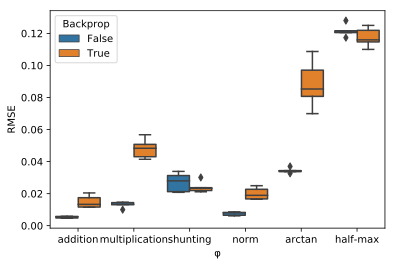

In [64]:
import pandas as pd
df = pd.DataFrame(data, columns=["φ", "Seed", "Backprop", "RMSE"])

import seaborn as sns
plt.figure()
sns.boxplot(data=df, x="φ", y="RMSE", hue="Backprop")
plt.show()

In [ ]:
res = run_benchmarks(benchmarks, benchmark_test_functions)

In [ ]:
from datetime import datetime
import json
with open('results_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.json', 'w') as outfile:
    json.dump(res, outfile)

In [ ]:
def analyse_results(results):
    # Reorganise the data
    data = {}
    for res in results:
        if not res[1] in data:
            data[res[1]] = {}
        if not res[0] in data[res[1]]:
            data[res[1]][res[0]] = {
                "optimized": [],
                "reference": []
            }
        data[res[1]][res[0]]["optimized"].append(res[3])
        data[res[1]][res[0]]["reference"].append(res[4])

    # Calculate mean and standard deviation, construct result tables
    res = {}
    for test_name, test in data.items():
        for method_name, method in test.items():
            for key, arr in method.items():
                if not (key + "_mean") in res:
                    res[key + "_mean"] = {}
                    res[key + "_stddev"] = {}
                if not test_name in res[key + "_mean"]:
                    res[key + "_mean"][test_name] = {}
                    res[key + "_stddev"][test_name] = {}
                res[key + "_mean"][test_name][method_name] = np.mean(arr)
                res[key + "_stddev"][test_name][method_name] = np.sqrt(np.var(arr))                

    return res

In [ ]:
import pandas
tables = analyse_results(res)

In [ ]:
pandas.DataFrame(tables["optimized_mean"])

In [ ]:
pandas.DataFrame(tables["optimized_stddev"])

In [ ]:
pandas.DataFrame(tables["reference_mean"])

In [ ]:
pandas.DataFrame(tables["reference_stddev"])